# Задача Bike Sharing Demand 2 попытка

** Первая часть задачи потерпела неудачу - модель вышла не очень точной. Пробуем снова опираясь на первой части!!!***


Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

In [19]:
from sklearn import cross_validation, grid_search, linear_model, metrics 
from sklearn import pipeline, preprocessing

import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**1. Загрузка данных**

In [3]:
# Фактически данные представлены в виде матрицы "Объект - признак" 
# поэтому нам будет удобнее работать с ними как с dataframe:
raw_data=pd.read_csv('bike_sharing_demand.csv', header=0, sep=',')
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [4]:
# смотрим размер наших данных
print raw_data.shape
# смотрим есть ли тут пропущенные значения если они есть надо думать как их обработать
raw_data.isnull().values.any()

(10886, 12)


False

**2. Предобработка данных**

In [5]:
#для того чтобы использовать все функции доступные для datetime преобразуем object:
# и потом  добавим новых 2 признака:
# 1. месяц
# 2. час

raw_data.datetime=raw_data.datetime.apply(pd.to_datetime)

raw_data['month']=raw_data.datetime.apply(lambda x: x.month)
raw_data['hour']=raw_data.datetime.apply(lambda x: x.hour)

In [6]:
# Потом разделим наши данные и по логике наши данные привязаны ко времени
# мы знаем день и час на которые мы хотим их оценить в этом случае 
# удобнее разбить данные по времени. Итак будем строить модель данных на данных 
# за более ранний период и оценивать ее качество на данных за более поздний период
# отправим последние данные в отложенный dataset
train_data=raw_data.iloc[:-1000, :]
hold_out_test_data=raw_data.iloc[-1000:, :]

In [7]:
# посмотрим полученные объекты:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [8]:
#Обработаем тренировочные данные для этого 
# 1. вырезаем цель в label
# 2. убираем datetime т.к. фактически это уже идентификатор объекта 
# 3. вырезаем столбцы 'casual', 'registered' в сумме дают значение цели (см.1 часть)

train_label=train_data['count'].values
train_data=train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [9]:
#Обработаем тестовые данные для этого 
# 1. вырезаем цель в label
# 2. убираем datetime т.к. фактически это уже идентификатор объекта
test_label = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

** Тут начинается отличие от предидущей модели где данные имели только численный тип
теперь же мы хотим обработать все признаки**
Но если данные отличаются по типам то и методы обработки должны будут отличаться поймем где находяться в тестовых данных данные какого типа

In [10]:
# firstly take a "boolean" columns in our array
# find out INDEXES of this columns. 
# "holiday" & "workingday" are BOOLEAN
binary_data_columns=["holiday", "workingday"]
binary_data_indeces=np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)
print binary_data_columns 
print binary_data_indeces

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [11]:
# secondary take a "categorical" columns in our array
# find out INDEXES of this columns. 
# "season", "weather", "month" are BOOLEAN
categorical_data_columns=["season", "weather", "month"]
categorical_data_indeces=np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)
print categorical_data_columns 
print categorical_data_indeces

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [12]:
# Then take a "numeric" columns in our array
# find out INDEXES of this columns. 
# "season", "weather", "month" are BOOLEAN
numeric_data_columns=["temp", "atemp", "humidity", "windspeed", "hour"]
numeric_data_indeces=np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)
print numeric_data_columns 
print numeric_data_indeces

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


** 3. Построим Pipeline **

In [13]:
#построим модель при этом возьмем те параметры которые
# мы уже подобрали в прошлую попытку как оптимальные при наших данных
# {'regression__n_iter': 3, 'regression__loss': 'squared_loss', 
# 'scaling__with_mean': 0, 'regression__alpha': 0.01, 
# 'regression__penalty': 'l2'}

regressor = linear_model.SGDRegressor(random_state=0
                                         , n_iter=3
                                         , loss='squared_loss'
                                         , penalty='l2')

In [32]:
#теперь построим Pipeline. Эта цепь будет несколько сложнее:
# сначала разбить даные по типам проработать а 
# затем нужно соединить в некотором порядке(FeatureUnion) 


estimator = pipeline.Pipeline(steps = [
        ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        #binary устраивает нас в этом же виде
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indeces])),
        #numeric тут сначала отделим затем масштабируем
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
                  ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indeces])),
                  ('scaling', preprocessing.StandardScaler(with_mean = 0.)) 
                            ])),
        #categorical тут отделим затем преобразовываем в нумерический вид наши категории (hot_encoding) 
        ('categorical_variables_processing', pipeline.Pipeline(steps =[
                  ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indeces])),
                  ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))   
                            ]))
          ])),
        ('model_fitting', regressor)])


In [33]:
#обучаем
estimator.fit(train_data, train_label)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000B800128>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))])

In [35]:
#оценим качество
metrics.mean_absolute_error(test_label, estimator.predict(test_data))
#ранее было 119.98978845935379
# значит преобразование не дало существенного результата

120.17177172806858

** 4.Подбор параметров **

In [36]:
# посмотрим какие параметры тут доступны
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__transformer_weights',
 'feature_processing__transformer_list',
 'model_fitting__fit_intercept',
 'feature_processing',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',
 'model_fitting__l1_ratio',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'feature_processing__categorical_variables_processing__hot_encoding_

In [40]:
# переберем только 2 параметра
parameters_grid={
    'model_fitting__alpha':[0.0001, 0.001, 0.1],
    'model_fitting__eta0':[0.001, 0.05],
}

In [41]:
grid_cv=grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=4)

In [42]:
%%time
grid_cv.fit(train_data, train_label)

Wall time: 2.35 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000B800128>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.001, 0.05], 'model_fitting__alpha': [0.0001, 0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [43]:
print grid_cv.best_score_
print grid_cv.best_params_

-104.61097793
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 0.1}


**5.Оценка по отложенному тесту**

In [44]:
test_prediction=grid_cv.best_estimator_.predict(test_data)

In [46]:
metrics.mean_absolute_error(test_label, test_prediction)

126.17670701473044

In [48]:
print test_label[:20]
print test_prediction[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]
[ 143.24020824  166.18559326  212.41847539  243.66840089  262.21027027
  255.95729611  280.35929884  307.46605276  313.16392458  323.56466813
  320.60577642  313.12562495  294.67280622  279.49996563  269.67904685
  240.31743647  244.881957     52.82798241   60.3789872    67.92999199]


(-100, 1100)

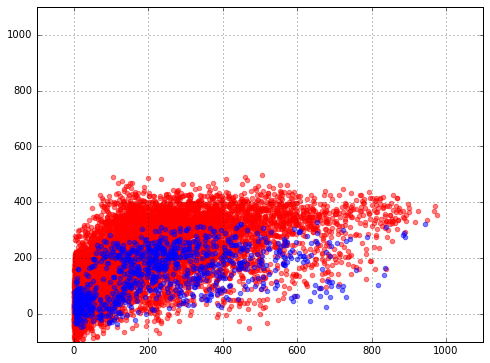

In [49]:
pylab.figure(figsize(8, 6))

pylab.grid(True)
pylab.scatter(train_label, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_label, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

по графику мы видим что область точек далека от диогональной области которая получилась бы в случае хорошей модели значит -
**Результат снова плохой **
Почему:  **мы строим линейную модель ** т.к. предполагаем линейную зависимость между признаками и целевой переменной но видимо это не всегда так значит можно:
1. придумать новые признаки и улучшить модель
2. взять другую более сложную модель для обучения

# ДРУГАЯ МОДЕЛЬ

In [50]:
# модель случайный лес
from sklearn.ensemble import RandomForestRegressor

In [51]:
regressor = RandomForestRegressor(random_state=0, 
                                  max_depth=20, 
                                  n_estimators=50)

In [52]:
# повторим преобразования
estimator = pipeline.Pipeline(steps = [
        ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        #binary устраивает нас в этом же виде
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indeces])),
        #numeric тут сначала отделим затем масштабируем
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
                  ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indeces])),
                  ('scaling', preprocessing.StandardScaler(with_mean = 0.)) 
                            ])),
        #categorical тут отделим затем преобразовываем в нумерический вид наши категории (hot_encoding) 
        ('categorical_variables_processing', pipeline.Pipeline(steps =[
                  ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indeces])),
                  ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))   
                            ]))
          ])),
        ('model_fitting', regressor)])

In [54]:
#обучим
estimator.fit(train_data, train_label)
#оценим качество
metrics.mean_absolute_error(test_label, estimator.predict(test_data))

79.465803762612722

In [55]:
#кажется лучше
print test_label[:10]
print estimator.predict(test_data)[:10]

[525 835 355 222 228 325 328 308 346 446]
[ 409.565       505.56        256.14066667  165.5502619   206.48474784
  265.73960439  254.49615818  317.85774486  282.66963263  441.59333333]


(-100, 1100)

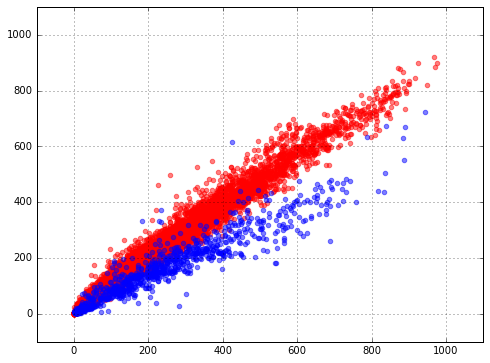

In [57]:
#Отрисуем
pylab.figure(figsize(8, 6))

pylab.grid(True)
pylab.scatter(train_label, estimator.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_label, estimator.predict(test_data), alpha=0.5, color='blue')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

Да модель явно лучше так как области уже принимают диоганальные графики !!!!